In [1]:
import pandas as pd
import numpy as np
import json
import re
from ast import literal_eval
from fuzzywuzzy import fuzz

In [2]:
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [3]:
def process_test_data(test_set_labeled):
    test_set_labeled=test_set_labeled.loc[~test_set_labeled["task_annotation"].isna()]
    test_set_labeled=test_set_labeled.loc[~test_set_labeled["method_annotation"].isna()]
    
    test_set_labeled=test_set_labeled.assign(task_annotation=test_set_labeled.task_annotation.str.lower().str.replace(" ,",",").str.replace(", ",",").str.split(","))

    test_set_labeled=test_set_labeled.assign(method_annotation=test_set_labeled.method_annotation.str.lower().str.replace(" ,",",").str.replace(", ",",").str.split(","))

    test_set_labeled=test_set_labeled.assign(org_annotation=test_set_labeled.org_annotation.str.lower().str.replace(" ,",",").str.replace(", ",",").str.split(","))

    test_set_labeled=test_set_labeled.loc[:,['ID','text','task_annotation', 'method_annotation', 'org_annotation']]

    return test_set_labeled

In [4]:
data_path="../data/"
output_path="../outputs/"

In [5]:
test_set_labeled=pd.read_csv(output_path+"general/test_set_final.csv")

methods_gpt3=pd.read_csv(output_path+"sg_ie/gpt3/GPT3_responses_method2_cleaned_f.csv")
tasks_gpt3=pd.read_csv(output_path+"sg_ie/gpt3/GPT3_responses_task_cleaned_f2.csv")

orgs=pd.read_csv(output_path+"sg_ie/organizations_test_stanza_ontonotes_final.csv")
df_lan=pd.read_csv(output_path+"general/test_set_language.csv")

In [6]:
df_labels_scirex=pd.read_json(output_path+"sg_ie/test_scirex_tasks_methods_clusters_salient_final_f.json")

In [7]:
test_set_labeled=test_set_labeled.loc[test_set_labeled.label==1].reset_index(drop=True)

In [8]:
test_set_labeled.shape

(276, 17)

In [9]:
df_labels_scirex

,ID,task_scirex,method_scirex
0,miller-etal-2012-using,"[{'words': ['disambiguation', 'disambiguation'...","[{'words': ['distributional similarity'], 'val..."
1,kim-etal-2019-unsupervised,"[{'words': ['parsing', 'constituency grammar i...",[{'words': ['unsupervised recurrent neural net...
2,iyer-etal-2021-veealign,"[{'words': ['ontology alignment', 'ontology al...","[{'words': ['dual attention', 'dual attention ..."
3,patra-etal-2013-automatic,[{'words': ['automatic music mood classificati...,"[{'words': ['automatic methods'], 'value': 0, ..."
4,kazi-etal-2014-mitll,"[{'words': ['mt', 'mt', 'translating'], 'value...","[{'words': ['pro and drem optimization'], 'val..."
...,...,...,...
5083,owoputi-etal-2013-improved,"[{'words': ['part of speech tagging', 'part of...",[{'words': ['large - scale unsupervised word c...
5084,kang-etal-2020-neural,"[{'words': ['question answering', 'question an...",[{'words': ['transformer based policy network'...
5085,ligozat-2013-question,"[{'words': ['question classification', 'questi...",[]
5086,hozumi-etal-1993-integration,"[{'words': ['segmentation'], 'value': 0.398467...",[{'words': ['integration of morphological and ...


In [10]:

test_set_labeled=process_test_data(test_set_labeled)
df_labels_scirex=df_labels_scirex.loc[:,['ID','task_scirex','method_scirex']]
## organizations
orgs=orgs.assign(organization=orgs.organization.str.lower())
orgs=orgs.groupby(['ID'])['organization'].apply(list).reset_index()
## gpt 3
tasks_gpt3=tasks_gpt3.assign(tasks=tasks_gpt3.tasks.str.lower())
methods_gpt3=methods_gpt3.assign(methods=methods_gpt3.methods.str.lower())
tasks_gpt3=tasks_gpt3.groupby(['ID'])['tasks'].apply(list).reset_index()
methods_gpt3=methods_gpt3.groupby(['ID'])['methods'].apply(list).reset_index()

In [11]:
test_set=test_set_labeled.merge(tasks_gpt3,on=['ID'],how='left').merge(methods_gpt3,on=['ID'],how='left').merge(df_labels_scirex,on=['ID'],how='left').merge(orgs,on=['ID'],how='left')

In [12]:
test_set=test_set.loc[~test_set.task_scirex.isna(),:].reset_index(drop=True)

In [13]:
test_set=test_set.loc[~test_set.method_scirex.isna(),:].reset_index(drop=True)

In [14]:
for i,d in test_set.iterrows():
    tasks=[]
    methods=[]
    if len(d['task_scirex'])==0:
        for word in d['tasks']:
            tasks.append({'words':[word],'value':0,'top_word':word})
        test_set.at[i,'task_scirex']=tasks
    if len(d['method_scirex'])==0:
        for word in d['methods']:
            methods.append({'words':[word],'value':0,'top_word':word})
        test_set.at[i,'method_scirex']=methods
    

In [15]:
test_set.loc[test_set.method_scirex.apply(lambda x:len(x))==0]

,ID,text,task_annotation,method_annotation,org_annotation,tasks,methods,task_scirex,method_scirex,organization


In [16]:
test_set=test_set.reset_index(drop=True)

In [17]:
test_set.loc[test_set.method_scirex.isna()]

,ID,text,task_annotation,method_annotation,org_annotation,tasks,methods,task_scirex,method_scirex,organization


In [18]:
test_set.shape

(103, 10)

In [19]:
def lev_sim(actual, predicted):
    if predicted == []:
        return 0
    print("aa::::",actual)
    print(predicted)
    
    predicted_max=[]
    for p in predicted:
        max_ratio=0
        for pp in p['words']:
            for a in actual:
                ratio = fuzz.partial_ratio(a.lower(), pp.lower())
                if ratio>max_ratio:
                    max_ratio=ratio
        predicted_max.append(max_ratio)
    return max(predicted_max)

In [20]:
test_set.loc[test_set.method_scirex.isna()]

,ID,text,task_annotation,method_annotation,org_annotation,tasks,methods,task_scirex,method_scirex,organization


In [21]:
test_set=test_set.loc[~test_set.task_scirex.isna(),:].reset_index(drop=True)

In [22]:
for i,d in test_set.iterrows():
    actual=d['task_annotation']
    actual = [x for x in actual if str(x) != 'nan']
    
    actual_m=d['method_annotation']
    actual_m = [x for x in actual_m if str(x) != 'nan']
    
    predicted_sci=d['task_scirex']
    ratio_sci=lev_sim(actual, predicted_sci)
    test_set.loc[i,'task_sci_ratio']=ratio_sci
    
    predicted_sci_m=d['method_scirex']
    ratio_sci_m=lev_sim(actual_m, predicted_sci_m)
    test_set.loc[i,'method_sci_ratio']=ratio_sci_m
    
    print(d['text'])
    #print(actual_m)
    #print(predicted_m)
    #print(ratio_m)
    
    print(actual_m)
    print(predicted_sci_m)
    print(ratio_sci_m)

aa:::: ['contrastive automatic analysis of verbs']
[{'words': ['automatic distinction'], 'value': 0, 'top_word': 'automatic distinction'}, {'words': ['contrastive automatic analysis of verbs'], 'value': 0, 'top_word': 'contrastive automatic analysis of verbs'}, {'words': ['semantic annotation'], 'value': 0, 'top_word': 'semantic annotation'}, {'words': ['semantic annotation'], 'value': 0, 'top_word': 'semantic annotation'}]
aa:::: ['semantic annotation']
[{'words': ['semantic annotation'], 'value': 0, 'top_word': 'semantic annotation'}, {'words': ['contrastive analysis'], 'value': 0, 'top_word': 'contrastive analysis'}, {'words': ['medical terminology'], 'value': 0, 'top_word': 'medical terminology'}]
Towards Automatic Distinction between Specialized and Non-Specialized Occurrences of Verbs in Medical Corpora. The medical field gathers people of different social statuses, such as students, pharmacists, managers, biologists, nurses and mainly medical doctors and patients, who represent 

In [23]:

test_set=test_set.assign(correct_ratio_sci_task=np.where(test_set.task_sci_ratio>=75,1,0))
test_set=test_set.assign(correct_ratio_sci_method=np.where(test_set.method_sci_ratio>=75,1,0))


In [24]:
def get_metrics_colors(actual,predicted):
    if predicted == []:
        return (0,0,0,[],[],[],[],[])
    act_set=list(dict.fromkeys(actual))
    len_pred=len(predicted)
    len_act=len(act_set)
    act_matches=[]
    match_list=set()
    golden=set()
    golden_match=set()
    unmatch=set()
    match_group=set()
    for a in act_set:
        scores=[]
        match=0
        score_max=0
        value_max=''
        val_max_int=''
        position=0
        position_max=None
        abb_flag=''
        for p in predicted:
            internal_max=0
            for pp in p['words']:
                unmatch.add(pp)
                ratio = fuzz.partial_ratio(a.lower(), pp.lower())
                abb="".join(e[0] for e in pp.split())
                print("comparing ",a," :with: ",pp," ::result::",ratio)
                if  (ratio>internal_max):
                    internal_max=ratio
                    val_max_int=pp
                if abb==a:
                    internal_max=80
                    val_max_int=pp
                    
            if (internal_max>=75) & (internal_max>score_max):
                score_max=internal_max
                value_max=val_max_int
                position_max=position
                match=1
            position+=1
        
        golden.add(a)
        if value_max!='':
            match_list.add(value_max)
            unmatch.remove(value_max)
            golden.remove(a)
            golden_match.add(a)
            match_group=match_group.union(predicted[position_max]["words"])
            match_group.remove(value_max)
            predicted.pop(position_max)
            
        
        act_matches.append(match)
    unmatch = [e for e in unmatch if e not in match_group]
    correct_complete=sum(act_matches)
    precision = correct_complete / len_pred
    recall = correct_complete / len_act
    if (precision+recall>0):
        f1=2*(precision*recall)/(precision+recall)
    else:
        f1=0
    return (f1,precision,recall,golden,golden_match,match_list,unmatch,match_group)

In [25]:
test_set.loc[test_set.task_scirex.isna()]

,ID,text,task_annotation,method_annotation,org_annotation,tasks,methods,task_scirex,method_scirex,organization,task_sci_ratio,method_sci_ratio,correct_ratio_sci_task,correct_ratio_sci_method


In [26]:
test_set.loc[test_set.ID=='soh-etal-2019-legal']


,ID,text,task_annotation,method_annotation,org_annotation,tasks,methods,task_scirex,method_scirex,organization,task_sci_ratio,method_sci_ratio,correct_ratio_sci_task,correct_ratio_sci_method
1,soh-etal-2019-legal,Legal Area Classification: A Comparative Study...,[legal area classification],"[topic model, word embedding, language model]","[singapore academy of law, singapore supreme c...","[text classification, topic modeling, word emb...","[topic modeling, word embedding, language mode...","[{'words': ['legal area classification', 'clas...","[{'words': ['text classifiers'], 'value': 0, '...",NaN,100.0,100.0,1,1


In [27]:
test_set=test_set.loc[~test_set.task_scirex.isna(),:].reset_index(drop=True)

In [28]:
test_set['task_unmatch_golden']=[list() for _ in range(test_set.shape[0])]
test_set['task_match_golden']=[list() for _ in range(test_set.shape[0])]
test_set['task_match_predicted']=[list() for _ in range(test_set.shape[0])]
test_set['task_unmatch_pred']=[list() for _ in range(test_set.shape[0])]
test_set['task_match_group']=[list() for _ in range(test_set.shape[0])]
test_set['task_match_total']=[list() for _ in range(test_set.shape[0])]

In [29]:
test_set['method_unmatch_golden']=[list() for _ in range(test_set.shape[0])]
test_set['method_match_golden']=[list() for _ in range(test_set.shape[0])]
test_set['method_match_predicted']=[list() for _ in range(test_set.shape[0])]
test_set['method_unmatch_pred']=[list() for _ in range(test_set.shape[0])]
test_set['method_match_group']=[list() for _ in range(test_set.shape[0])]
test_set['method_match_total']=[list() for _ in range(test_set.shape[0])]

In [30]:
for i,d in test_set.iterrows():
    print(d['text'])
    predicted_sci=d['task_scirex'][:]
    predicted_sci_m=d['method_scirex'][:]
    actual=d['task_annotation']
    actual = [x for x in actual if str(x) != 'nan']

    
    actual_m=d['method_annotation']
    actual_m = [x for x in actual_m if str(x) != 'nan']
    print("predicted task: ",predicted_sci)
    print("predicted method: ",predicted_sci_m)
    #print(ratio_m)
    
    print("actual task: ",actual)
    print("actual method: ",actual_m)
       
    f1,precision,recall,golden,match_g,match_p,unmatch,match_group=get_metrics_colors(actual, predicted_sci)
    test_set.loc[i,'task_sci_f1']=f1
    test_set.loc[i,'task_sci_precision']=precision
    test_set.loc[i,'task_sci_recall']=recall
    test_set.at[i,'task_unmatch_golden']=list(golden)
    test_set.at[i,'task_match_golden']=list(match_g)
    test_set.at[i,'task_match_predicted']=list(match_p)
    test_set.at[i,'task_unmatch_pred']=list(unmatch)
    test_set.at[i,'task_match_group']=list(match_group)
    test_set.at[i,'task_match_total']=list(set(match_g).union(set(match_p)))

    
    
    f1,precision,recall,golden,match_g,match_p,unmatch,match_group=get_metrics_colors(actual_m, predicted_sci_m)
    test_set.loc[i,'method_sci_f1']=f1
    test_set.loc[i,'method_sci_precision']=precision
    test_set.loc[i,'method_sci_recall']=recall
    test_set.at[i,'method_unmatch_golden']=list(golden)
    test_set.at[i,'method_match_golden']=list(match_g)
    test_set.at[i,'method_match_predicted']=list(match_p)
    test_set.at[i,'method_unmatch_pred']=list(unmatch)
    test_set.at[i,'method_match_group']=list(match_group)
    test_set.at[i,'method_match_total']=list(set(match_g).union(set(match_p)))

    #print(predicted_sci)
    #print(test_set.loc[i,'task_sci_f1'])
    #print(test_set.loc[i,'task_sci_precision'])
    print(test_set.loc[i,'task_sci_recall'])
    print(test_set.loc[i,'method_sci_recall'])
    print()

Towards Automatic Distinction between Specialized and Non-Specialized Occurrences of Verbs in Medical Corpora. The medical field gathers people of different social statuses, such as students, pharmacists, managers, biologists, nurses and mainly medical doctors and patients, who represent the main actors. Despite their different levels of expertise, these actors need to interact and understand each other but the communication is not always easy and effective. This paper describes a method for a contrastive automatic analysis of verbs in medical corpora, based on the semantic annotation of the verbs nominal co-occurents. The corpora used are specialized in cardiology and distinguished according to their levels of expertise (high and low). The semantic annotation of these corpora is performed by using an existing medical terminology. The results indicate that the same verbs occurring in the two corpora show different specialization levels, which are indicated by the words (nouns and adjec

In [31]:
test_set.loc[test_set.ID=='soh-etal-2019-legal']
df_labels_scirex.loc[df_labels_scirex.ID=='soh-etal-2019-legal']

,ID,task_scirex,method_scirex
24,soh-etal-2019-legal,"[{'words': ['legal area classification', 'clas...","[{'words': ['text classifiers'], 'value': 0, '..."


<AxesSubplot:>

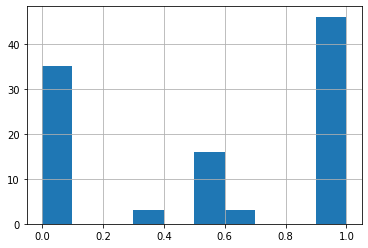

In [32]:
test_set.method_sci_recall.hist()

In [34]:
just100=test_set.iloc[:100]

In [35]:
np.mean(just100.task_annotation.apply(lambda x:len(x)))

1.21

In [36]:
np.mean(just100.method_annotation.apply(lambda x:len(x)))

1.69

In [37]:
np.mean(just100.task_scirex.apply(lambda x:len(x)))

2.91

In [38]:
np.mean(just100.method_scirex.apply(lambda x:len(x)))

2.82

In [39]:
len(set(just100.task_annotation.explode()))

116

In [40]:
len(set(just100.method_annotation.explode()))

159

In [41]:
1.21*100

121.0

In [42]:
1.69*100

169.0

In [33]:
#corefsalient  gpt3
(test_set.describe()*100).round(2)

,task_sci_ratio,method_sci_ratio,correct_ratio_sci_task,correct_ratio_sci_method,task_sci_f1,task_sci_precision,task_sci_recall,method_sci_f1,method_sci_precision,method_sci_recall
count,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00
mean,8806.80,7953.40,76.70,66.02,53.08,50.26,71.84,38.50,34.60,55.44
std,2141.53,2749.61,42.48,47.60,38.08,41.33,42.84,33.14,34.74,44.42
min,2400.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,8750.00,5000.00,100.00,0.00,22.50,12.70,33.33,0.00,0.00,0.00
50%,10000.00,10000.00,100.00,100.00,50.00,50.00,100.00,40.00,33.33,50.00
75%,10000.00,10000.00,100.00,100.00,100.00,100.00,100.00,66.67,50.00,100.00
max,10000.00,10000.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00


In [41]:
#corefsalient  gpt3
(test_set.describe()*100).round(2)

,task_sci_ratio,method_sci_ratio,correct_ratio_sci_task,correct_ratio_sci_method,task_sci_f1,task_sci_precision,task_sci_recall,method_sci_f1,method_sci_precision,method_sci_recall
count,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00
mean,8806.80,7953.40,76.70,66.02,53.08,50.26,71.84,38.22,34.36,55.11
std,2141.53,2749.61,42.48,47.60,38.08,41.33,42.84,33.10,34.72,44.45
min,2400.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,8750.00,5000.00,100.00,0.00,22.50,12.70,33.33,0.00,0.00,0.00
50%,10000.00,10000.00,100.00,100.00,50.00,50.00,100.00,40.00,33.33,50.00
75%,10000.00,10000.00,100.00,100.00,100.00,100.00,100.00,66.67,50.00,100.00
max,10000.00,10000.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00


In [32]:
#coref salient
(test_set.describe()*100).round(2)

,task_sci_ratio,method_sci_ratio,correct_ratio_sci_task,correct_ratio_sci_method,task_sci_f1,task_sci_precision,task_sci_recall,method_sci_f1,method_sci_precision,method_sci_recall
count,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00
mean,8727.18,7395.15,76.70,62.14,53.08,50.26,71.84,36.56,33.30,51.55
std,2380.32,3443.36,42.48,48.74,38.08,41.33,42.84,33.87,35.39,44.72
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,8750.00,4400.00,100.00,0.00,22.50,12.70,33.33,0.00,0.00,0.00
50%,10000.00,9700.00,100.00,100.00,50.00,50.00,100.00,40.00,25.00,50.00
75%,10000.00,10000.00,100.00,100.00,100.00,100.00,100.00,66.67,50.00,100.00
max,10000.00,10000.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00


In [33]:
#coref gpt3
(test_set.describe()*100).round(2)

,task_sci_ratio,method_sci_ratio,correct_ratio_sci_task,correct_ratio_sci_method,task_sci_f1,task_sci_precision,task_sci_recall,method_sci_f1,method_sci_precision,method_sci_recall
count,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00
mean,9177.67,8331.07,84.47,71.84,52.88,44.19,81.23,44.08,40.71,59.00
std,1837.78,2548.09,36.40,45.20,31.69,33.13,37.17,31.76,33.90,42.76
min,3300.00,2900.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,10000.00,6450.00,100.00,0.00,33.33,20.00,100.00,0.00,0.00,0.00
50%,10000.00,10000.00,100.00,100.00,50.00,40.00,100.00,50.00,40.00,60.00
75%,10000.00,10000.00,100.00,100.00,66.67,58.33,100.00,66.67,50.00,100.00
max,10000.00,10000.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00


In [33]:
## coref
(test_set.describe()*100).round(2)

,task_sci_ratio,method_sci_ratio,correct_ratio_sci_task,correct_ratio_sci_method,task_sci_f1,task_sci_precision,task_sci_recall,method_sci_f1,method_sci_precision,method_sci_recall
count,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00,10300.00
mean,9098.06,7772.82,84.47,67.96,52.88,44.19,81.23,42.13,39.42,55.11
std,2125.29,3348.87,36.40,46.89,31.69,33.13,37.17,32.86,34.79,43.40
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,10000.00,4900.00,100.00,0.00,33.33,20.00,100.00,0.00,0.00,0.00
50%,10000.00,10000.00,100.00,100.00,50.00,40.00,100.00,50.00,40.00,50.00
75%,10000.00,10000.00,100.00,100.00,66.67,58.33,100.00,66.67,50.00,100.00
max,10000.00,10000.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00
